# Assignment 1: Cluster analysis on gene expression data

Dependency install for google colab

In [ ]:
!pip install scikit-learn

In [ ]:
!pip install umap-learn

## Package import

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as kl
from sklearn.tree import DecisionTreeClassifier, plot_tree

## Helper function definition

In [ ]:
def get_color_map(labels):
    unique_labels = np.unique(labels)
    colors = plt.cm.tab20(range(len(unique_labels)))
    label_to_color = dict(zip(unique_labels, colors))
    return [label_to_color[label] for label in labels], label_to_color

def plot_pca_with_labels(features_pca, labels_list, titles, figsize=(12, 6), s=5):
    """
    Plots PCA scatter plots for multiple label sets.

    Args:
        features_pca (numpy.ndarray): PCA output, shape (n_samples, 2).
        labels_list (list of arrays): List of label arrays for coloring the points.
        titles (list of str): Titles for the subplots, corresponding to each label set.
        figsize (tuple): Figure size.
    """
    num_plots = len(labels_list)
    fig, axes = plt.subplots(1, num_plots, figsize=figsize)

    if num_plots == 1:  # Ensure axes is iterable even for a single plot
        axes = [axes]

    for i, (labels, title) in enumerate(zip(labels_list, titles)):
        # Get colors and label-to-color mapping
        colors, label_to_color = get_color_map(labels)

        # Scatter plot
        axes[i].scatter(features_pca[:, 0], features_pca[:, 1], c=colors, alpha=0.7, s=s)
        axes[i].set_title(title)
        axes[i].set_xlabel('PCA1')
        axes[i].set_ylabel('PCA2')

        # Create legend
        handles = [plt.Line2D([0], [0], marker='o', color=color, linestyle='', markersize=8, label=label)
                   for label, color in label_to_color.items()]
        axes[i].legend(handles=handles,
                       title="Labels",
                       loc='center right',
                       bbox_to_anchor=(1, 0.5))

    plt.tight_layout()
    plt.show()

def plot_two_axes(df, x_col, y1_col, y2_col, figsize=(10, 6)):
    """
    Plots two columns as lines and dots against a common x-axis,
    with dual y-axes and separate colors.

    Args:
        df (pd.DataFrame): The data to plot.
        x_col (str): Name of the column to use as x-axis.
        y1_col (str): Name of the first y-axis column.
        y2_col (str): Name of the second y-axis column.
        figsize (tuple): Size of the figure.
    """
    fig, ax1 = plt.subplots(figsize=figsize)

    # Define colors
    color1 = 'tab:blue'
    color2 = 'tab:orange'

    # Plot y1
    ax1.set_xlabel(x_col)
    ax1.set_ylabel(y1_col, color=color1)
    ax1.plot(df[x_col], df[y1_col], color=color1, label=f'{y1_col} (line)', linestyle='-', marker='o')
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.legend(loc='upper left')

    # Create a twin y-axis
    ax2 = ax1.twinx()
    ax2.set_ylabel(y2_col, color=color2)
    ax2.plot(df[x_col], df[y2_col], color=color2, label=f'{y2_col} (line)', linestyle='-', marker='x')
    ax2.tick_params(axis='y', labelcolor=color2)
    ax2.legend(loc='upper right')

    # Add grid and title
    ax1.grid(visible=True, which='both', axis='both', linestyle='--', alpha=0.5)
    plt.title(f'{y1_col} and {y2_col} vs {x_col}')

    plt.tight_layout()
    plt.show()

## Data loading (prerequisite: running the data download and preprocessing scripts)

In [ ]:
data_path = '.'
features = pd.read_csv(os.path.join(data_path, 'gtex_v8_features.csv'), index_col=0)
target = pd.read_csv(os.path.join(data_path, 'gtex_v8_target.csv'), index_col=0)
target = target.loc[features.columns,:]
print(features.shape, target.shape)
features.head()

(5000, 12385) (12385, 1)


,GTEX-1117F-0226-SM-5GZZ7,GTEX-1117F-0426-SM-5EGHI,GTEX-1117F-0526-SM-5EGHJ,GTEX-1117F-0626-SM-5N9CS,GTEX-1117F-0726-SM-5GIEN,GTEX-1117F-1326-SM-5EGHH,GTEX-1117F-2926-SM-5GZYI,GTEX-1117F-3226-SM-5N9CT,GTEX-111CU-0326-SM-5GZXO,GTEX-111CU-0626-SM-5EGHL,...,GTEX-ZZPU-0326-SM-5N9BJ,GTEX-ZZPU-0526-SM-5E44U,GTEX-ZZPU-0826-SM-5GZX5,GTEX-ZZPU-0926-SM-5GZYT,GTEX-ZZPU-1026-SM-5E457,GTEX-ZZPU-1126-SM-5N9CW,GTEX-ZZPU-1826-SM-5E43L,GTEX-ZZPU-2426-SM-5E44I,GTEX-ZZPU-2626-SM-5E45Y,GTEX-ZZPU-2726-SM-5NQ8O
Name,,,,,,,,,,,,,,,,,,,,,
ENSG00000225630.1,359.00,650.70,281.00,424.200,638.50,496.50,254.40,1275.00,689.00,1108.00,...,532.40,390.20,766.90,1003.00,927.40,992.00,752.20,435.80,706.90,1006.00
ENSG00000237973.1,27.95,68.36,24.55,8.134,101.80,23.62,37.27,136.70,35.53,48.26,...,37.94,42.57,51.71,136.90,251.30,133.80,223.20,53.87,123.20,58.84
ENSG00000248527.1,1433.00,5677.00,1537.00,1846.000,10320.00,4094.00,1928.00,7976.00,3055.00,3957.00,...,2980.00,2360.00,3060.00,8425.00,5625.00,6026.00,4052.00,2783.00,5835.00,3392.00
ENSG00000198744.5,23.14,246.20,22.87,8.578,32.52,47.43,25.34,31.61,13.68,28.60,...,65.53,18.77,20.33,32.82,38.98,401.10,32.29,49.22,71.98,17.57
ENSG00000188976.10,90.74,93.56,94.87,67.600,26.52,33.67,80.95,32.60,106.80,67.79,...,68.85,55.78,80.81,28.40,38.20,34.88,52.21,58.76,75.22,39.30


In [ ]:
target.head()

,SMTS
GTEX-1117F-0226-SM-5GZZ7,Adipose Tissue
GTEX-1117F-0426-SM-5EGHI,Muscle
GTEX-1117F-0526-SM-5EGHJ,Blood Vessel
GTEX-1117F-0626-SM-5N9CS,Blood Vessel
GTEX-1117F-0726-SM-5GIEN,Heart


In [ ]:
feature_to_symbol = pd.read_csv(os.path.join(data_path, 'gtex_v8_gene_id_to_symbol.csv'), index_col=0)
feature_to_symbol.head()

,Symbol
Name,
ENSG00000198938.2,MT-CO3
ENSG00000198804.2,MT-CO1
ENSG00000198886.2,MT-ND4
ENSG00000198899.2,MT-ATP6
ENSG00000198712.1,MT-CO2


## Data normalization

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features_transposed = features.T
features_normalized = pd.DataFrame(
    scaler.fit_transform(features_transposed.values),
    index=features_transposed.index,
    columns=features_transposed.columns)
features_normalized.head()

Name,ENSG00000225630.1,ENSG00000237973.1,ENSG00000248527.1,ENSG00000198744.5,ENSG00000188976.10,ENSG00000188290.10,ENSG00000187608.8,ENSG00000188157.14,ENSG00000078808.16,ENSG00000131584.18,...,ENSG00000168385.17,ENSG00000115694.14,ENSG00000176720.4,ENSG00000176946.11,ENSG00000168397.16,ENSG00000180902.17,ENSG00000150995.18,ENSG00000134107.4,ENSG00000134108.12,ENSG00000134109.10
GTEX-1117F-0226-SM-5GZZ7,-0.626273,-0.265057,-0.973464,-0.167578,1.185909,-0.435760,-0.269292,-0.043794,1.435037,-0.417784,...,0.502567,-0.103881,-0.228930,1.957930,0.337384,0.141125,-0.447495,0.044838,0.414799,0.482089
GTEX-1117F-0426-SM-5EGHI,-0.278058,-0.185182,0.710517,0.790997,1.279881,-0.716693,-0.305098,-0.962106,-0.438225,-0.640011,...,-0.964206,2.064578,-0.890814,1.264012,-1.063226,-0.801363,-0.743511,-0.538686,1.319014,-0.378968
GTEX-1117F-0526-SM-5EGHJ,-0.719385,-0.271778,-0.932198,-0.168738,1.323535,-0.153453,-0.210372,-0.523030,0.863433,-0.552295,...,0.674341,-0.606801,-0.828172,0.907161,-0.063828,-0.383858,1.563913,2.036006,0.443259,0.575027
GTEX-1117F-0626-SM-5N9CS,-0.548441,-0.304226,-0.809589,-0.230156,0.414804,1.615239,-0.124557,0.722050,1.309166,-0.160319,...,1.378161,0.747480,0.156766,0.473285,1.071083,0.464768,0.429249,-0.331870,0.084662,0.239346
GTEX-1117F-0726-SM-5GIEN,-0.292622,-0.119084,2.552816,-0.127268,-0.954126,-0.147566,-0.270147,-0.496763,-0.294583,-0.518762,...,-0.745003,-1.011207,-0.774555,-0.907483,-0.873510,-0.696539,-0.627874,0.001371,-1.126379,-0.381514


In [ ]:
X = features_normalized.copy()
nan_cols = X.columns[X.isna().any()].tolist()
print("Missing/Improper features", nan_cols)
X = X.drop(columns=nan_cols)
print(X.shape)

Missing/Improper features []
(12385, 5000)


## Dimensionality reduction for visualization

PCA

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
features_pca = pca.fit_transform(X)
pca_df = pd.DataFrame(data=features_pca, columns=['PC1', 'PC2'])

UMAP

In [ ]:
from umap import UMAP
umap = UMAP(n_components=2)
features_umap = umap.fit_transform(X)
umap_df = pd.DataFrame(data=features_umap, columns=['UMAP1', 'UMAP2'])

In [ ]:
y = target.loc[:, 'SMTS']

## Clustering Analysis

In [ ]:
from sklearn.metrics import adjusted_rand_score as ari
from sklearn.metrics import normalized_mutual_info_score as nmi
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score

### KMeans with replication

In [ ]:
from sklearn.cluster import KMeans

np.random.seed(0)
Ks = range(5, 15)
n_reps = 5
mean_aris = []
mean_nmis = []
mean_sils = []
mean_chs = []

for k in Ks:
    print(f"Running Kmeans with k = {k} ...")
    labels = []
    centroids = []
    aris = []
    nmis = []
    sils = []
    chs = []

    for _ in range(n_reps):
        print(f"\tRep: {_+1}/{n_reps}")
        model = KMeans(n_clusters=k, n_init="auto")
        label_pred = model.fit_predict(X)
        labels.append(label_pred)
        centroids.append(model.cluster_centers_)

        aris.append([ari(
            label_pred,
            y.values
        )])

        nmis.append([nmi(
            label_pred,
            y.values
        )])

        sils.append([silhouette_score(
            X,
            label_pred
        )])

        chs.append([calinski_harabasz_score(
            X,
            label_pred
        )])

    mean_aris.append(np.mean(aris))
    mean_nmis.append(np.mean(nmis))
    mean_sils.append(np.mean(sils))
    mean_chs.append(np.mean(chs))

Running Kmeans with k = 5 ...
	Rep: 1/5
	Rep: 2/5
	Rep: 3/5
	Rep: 4/5
	Rep: 5/5
Running Kmeans with k = 6 ...
	Rep: 1/5
	Rep: 2/5
	Rep: 3/5
	Rep: 4/5
	Rep: 5/5
Running Kmeans with k = 7 ...
	Rep: 1/5
	Rep: 2/5
	Rep: 3/5
	Rep: 4/5
	Rep: 5/5
Running Kmeans with k = 8 ...
	Rep: 1/5
	Rep: 2/5
	Rep: 3/5
	Rep: 4/5
	Rep: 5/5
Running Kmeans with k = 9 ...
	Rep: 1/5
	Rep: 2/5
	Rep: 3/5
	Rep: 4/5
	Rep: 5/5
Running Kmeans with k = 10 ...
	Rep: 1/5
	Rep: 2/5
	Rep: 3/5
	Rep: 4/5
	Rep: 5/5
Running Kmeans with k = 11 ...
	Rep: 1/5
	Rep: 2/5
	Rep: 3/5
	Rep: 4/5
	Rep: 5/5
Running Kmeans with k = 12 ...
	Rep: 1/5
	Rep: 2/5
	Rep: 3/5
	Rep: 4/5
	Rep: 5/5
Running Kmeans with k = 13 ...
	Rep: 1/5
	Rep: 2/5
	Rep: 3/5
	Rep: 4/5
	Rep: 5/5
Running Kmeans with k = 14 ...
	Rep: 1/5
	Rep: 2/5
	Rep: 3/5
	Rep: 4/5
	Rep: 5/5


In [ ]:
external_metric_df = pd.DataFrame(
    {
        "K": list(Ks),
        "Mean ARI": mean_aris,
        "Mean NMI": mean_nmis
    }
)

internal_metric_df = pd.DataFrame(
    {
        "K": list(Ks),
        "Mean Silhouette Score": mean_sils,
        "Mean CH Score": mean_chs
    }
)

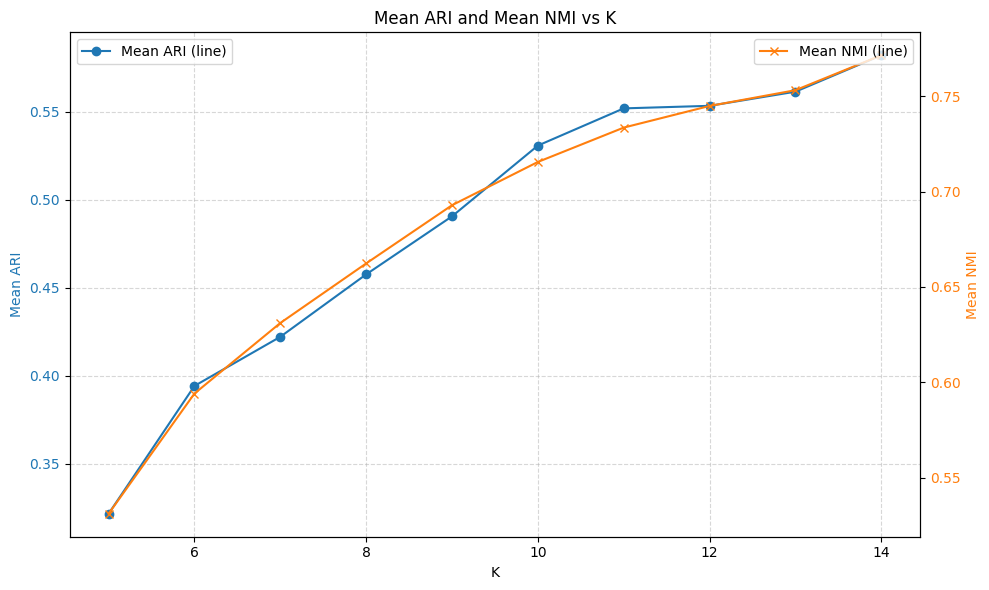

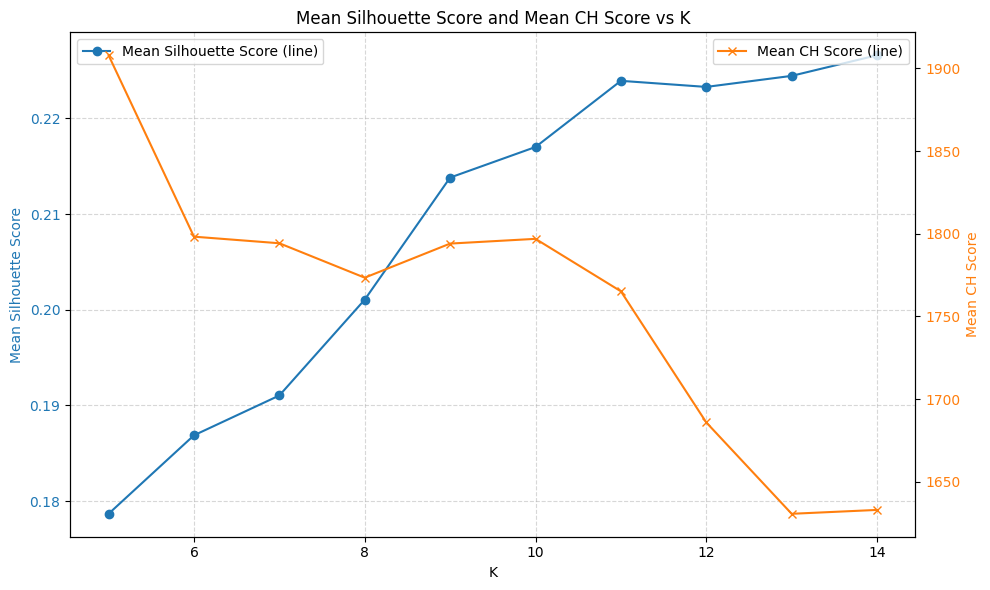

In [ ]:
plot_two_axes(external_metric_df, x_col='K', y1_col='Mean ARI', y2_col='Mean NMI')
plot_two_axes(internal_metric_df, x_col='K', y1_col='Mean Silhouette Score', y2_col='Mean CH Score')

In [ ]:
model = KMeans(n_clusters=10, n_init="auto")
pred = model.fit_predict(X)
cluster_labels = pd.Series(pred).astype("category").rename("Cluster labels")
cluster_labels

,Cluster labels
0,7
1,3
2,2
3,7
4,3
...,...
12380,3
12381,8
12382,2
12383,3


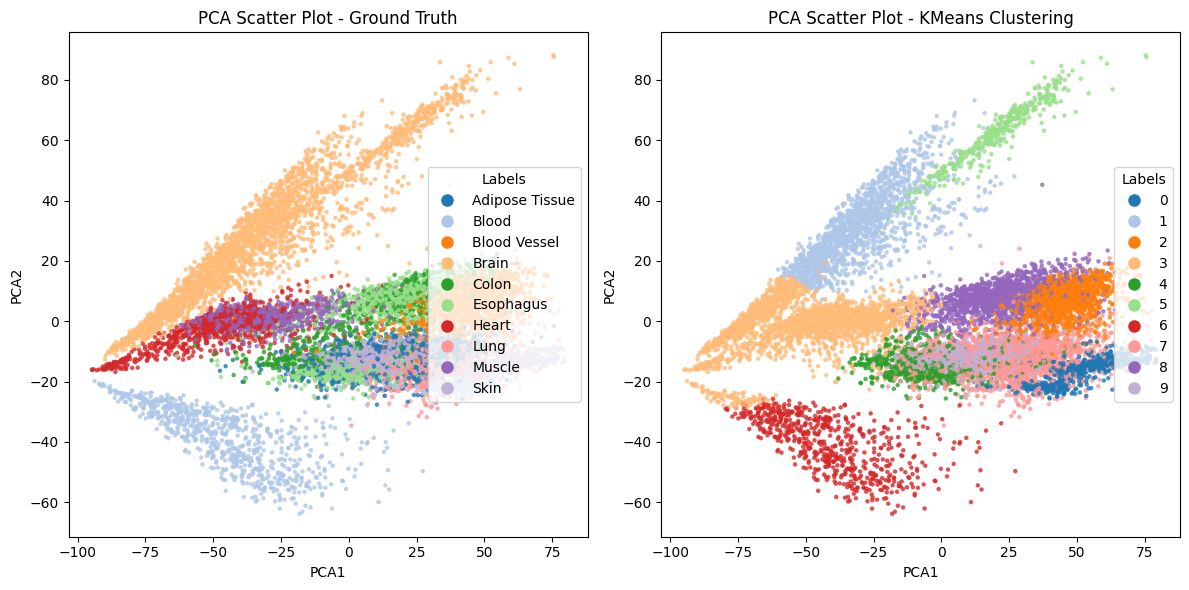

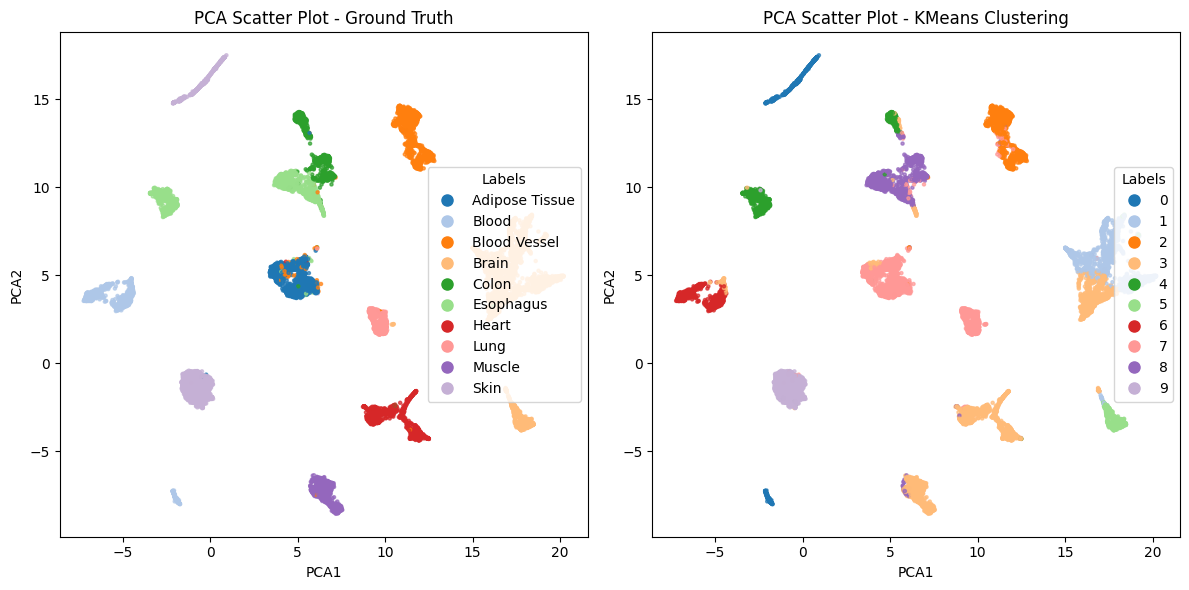

In [ ]:
plot_pca_with_labels(
    features_pca,
    labels_list=[y.values, cluster_labels],
    titles=["PCA Scatter Plot - Ground Truth", "PCA Scatter Plot - KMeans Clustering"],
)

plot_pca_with_labels(
    features_umap,
    labels_list=[y.values, cluster_labels],
    titles=["PCA Scatter Plot - Ground Truth", "PCA Scatter Plot - KMeans Clustering"],
)

In [ ]:
clt = DecisionTreeClassifier(max_depth=3, random_state=0).fit(X, pred)

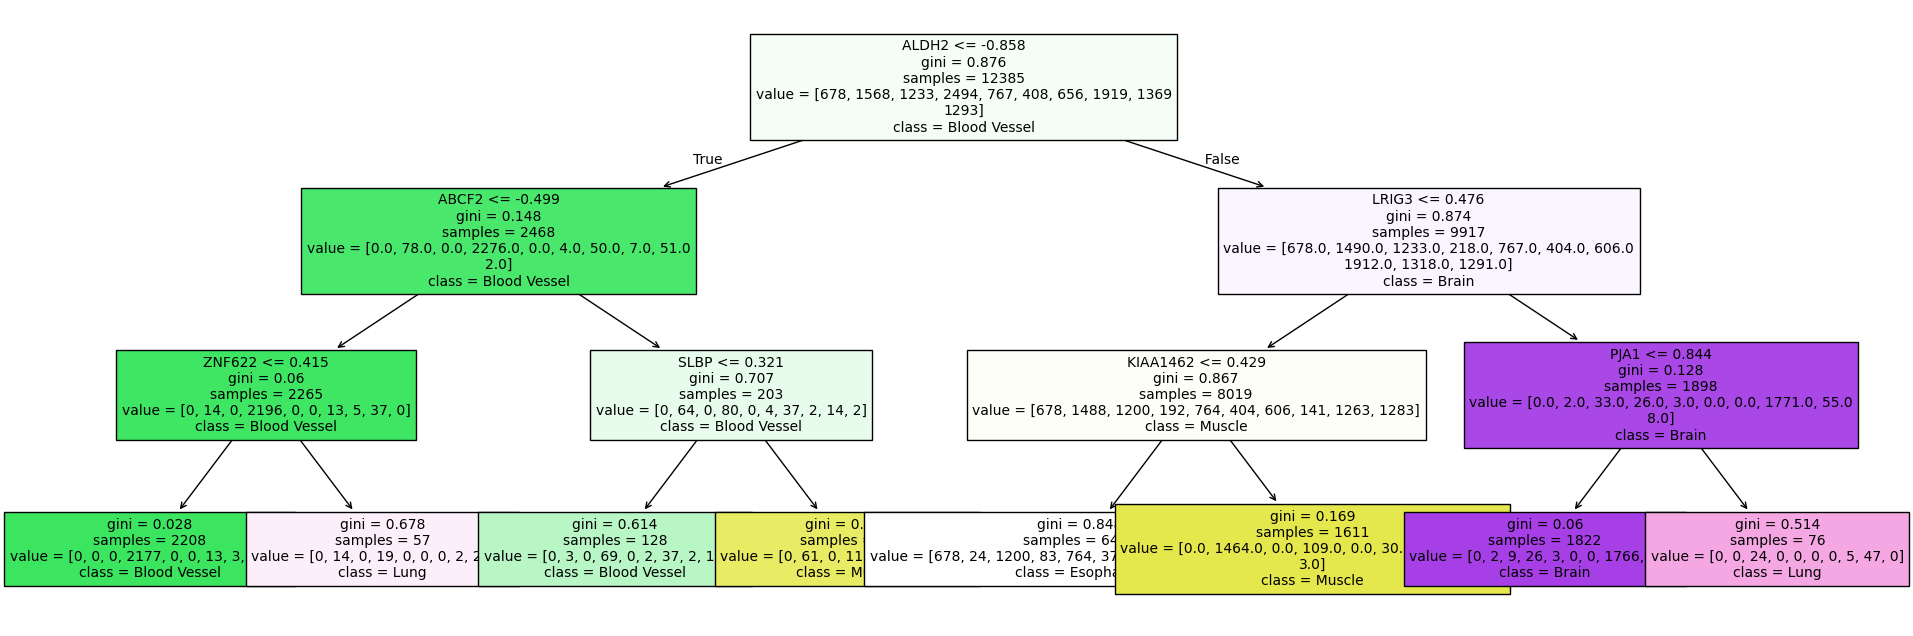

In [ ]:
fig = plt.figure(figsize=(24, 8))
_ = plot_tree(
    clt,
    filled=True,
    fontsize=10,
    feature_names=feature_to_symbol.astype(str).iloc[:,0].tolist(),
    class_names=y.values
)

### Hierarchical clustering

In [ ]:
from sklearn.cluster import AgglomerativeClustering

np.random.seed(0)
Ks = range(5, 15)
n_reps = 5

mean_aris_agg = []
mean_nmis_agg = []
mean_sils_agg = []
mean_chs_agg = []

for k in Ks:
    print(f"Running Hierarchical clustering with k = {k} ...")
    model = AgglomerativeClustering(n_clusters=k)
    label_pred = model.fit_predict(X)

    mean_aris_agg.append(ari(
        label_pred,
        y.values
    ))
    mean_nmis_agg.append(nmi(
        label_pred,
        y.values
    ))
    mean_sils_agg.append(silhouette_score(
        X,
        label_pred
    ))
    mean_chs_agg.append(calinski_harabasz_score(
        X,
        label_pred
    ))

Running Hierarchical clustering with k = 5 ...
Running Hierarchical clustering with k = 6 ...
Running Hierarchical clustering with k = 7 ...
Running Hierarchical clustering with k = 8 ...
Running Hierarchical clustering with k = 9 ...
Running Hierarchical clustering with k = 10 ...
Running Hierarchical clustering with k = 11 ...
Running Hierarchical clustering with k = 12 ...
Running Hierarchical clustering with k = 13 ...
Running Hierarchical clustering with k = 14 ...


In [ ]:
external_metric_agg_df = pd.DataFrame(
    {
        "K": list(Ks),
        "Mean ARI": mean_aris_agg,
        "Mean NMI": mean_nmis_agg
    }
)

internal_metric_agg_df = pd.DataFrame(
    {
        "K": list(Ks),
        "Mean SIL": mean_sils_agg,
        "Mean CH": mean_chs_agg
    }
)

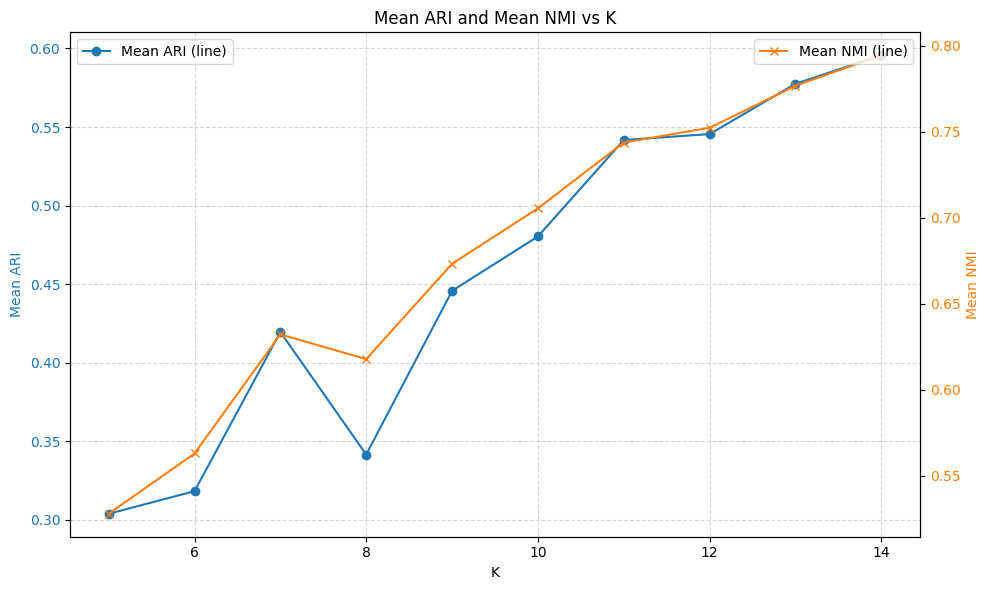

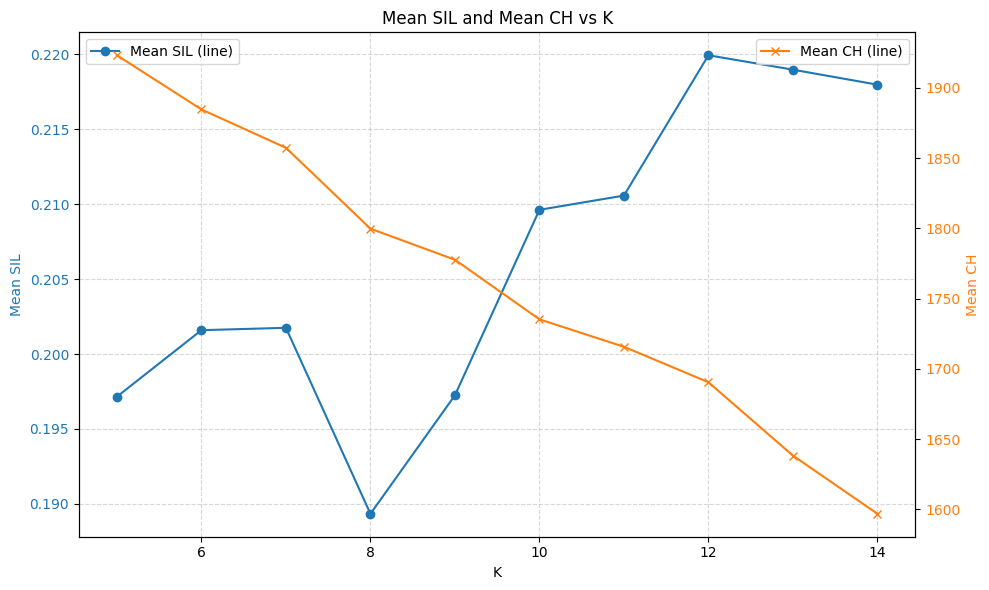

In [ ]:
plot_two_axes(external_metric_agg_df, x_col='K', y1_col='Mean ARI', y2_col='Mean NMI')
plot_two_axes(internal_metric_agg_df, x_col='K', y1_col='Mean SIL', y2_col='Mean CH')

In [ ]:
model = AgglomerativeClustering(n_clusters=12)
pred = model.fit_predict(X)
cluster_labels = pd.Series(pred).astype("category").rename("Cluster labels")
cluster_labels

,Cluster labels
0,3
1,9
2,4
3,3
4,2
...,...
12380,2
12381,10
12382,4
12383,9


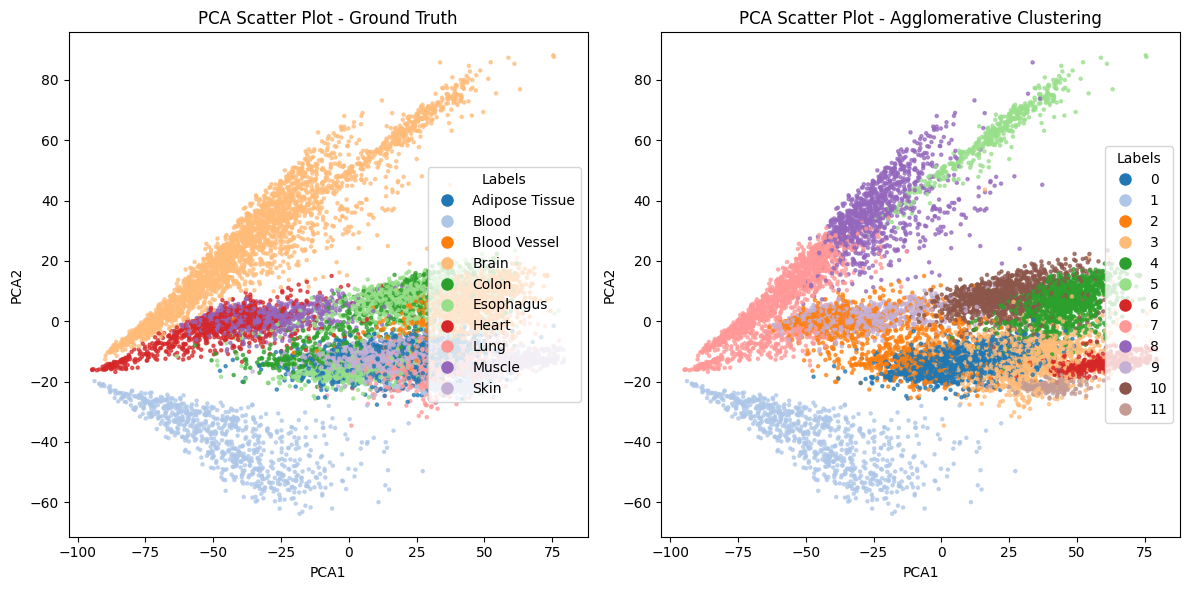

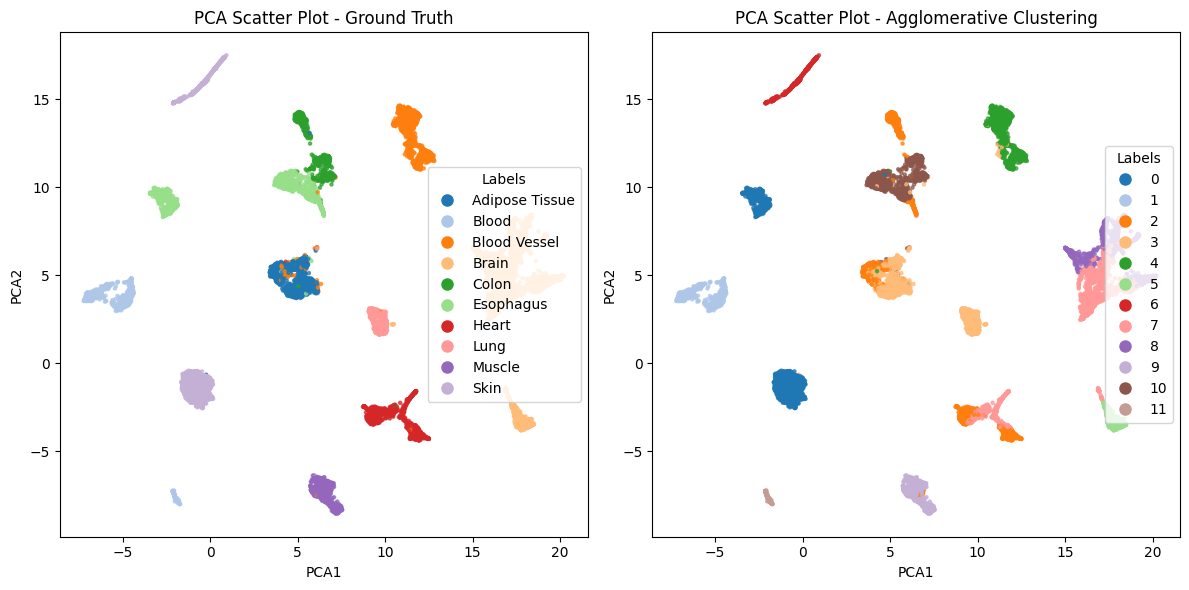

In [ ]:
plot_pca_with_labels(
    features_pca,
    labels_list=[y.values, cluster_labels],
    titles=["PCA Scatter Plot - Ground Truth", "PCA Scatter Plot - Agglomerative Clustering"],
)

plot_pca_with_labels(
    features_umap,
    labels_list=[y.values, cluster_labels],
    titles=["PCA Scatter Plot - Ground Truth", "PCA Scatter Plot - Agglomerative Clustering"],
)

In [ ]:
clt = DecisionTreeClassifier(max_depth=3, random_state=0).fit(X, pred)

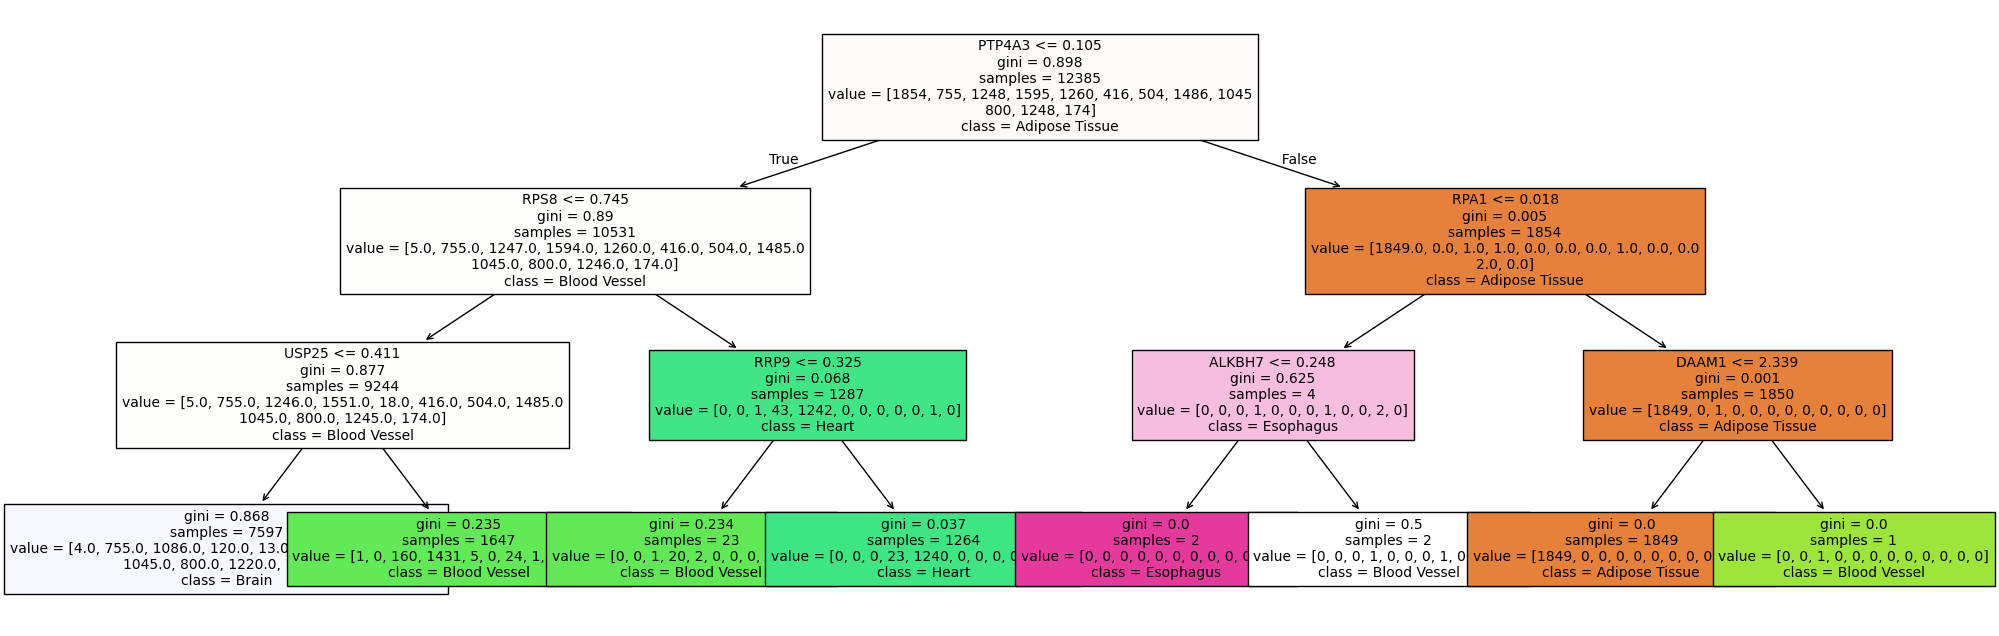

In [ ]:
fig = plt.figure(figsize=(24, 8))
_ = plot_tree(
    clt,
    filled=True,
    fontsize=10,
    feature_names=feature_to_symbol.astype(str).iloc[:,0].tolist(),
    class_names=y.values
)

## Exploration of genes driving tissue classification

In [ ]:
clt_truth = DecisionTreeClassifier(max_depth=5, random_state=0).fit(X, y)

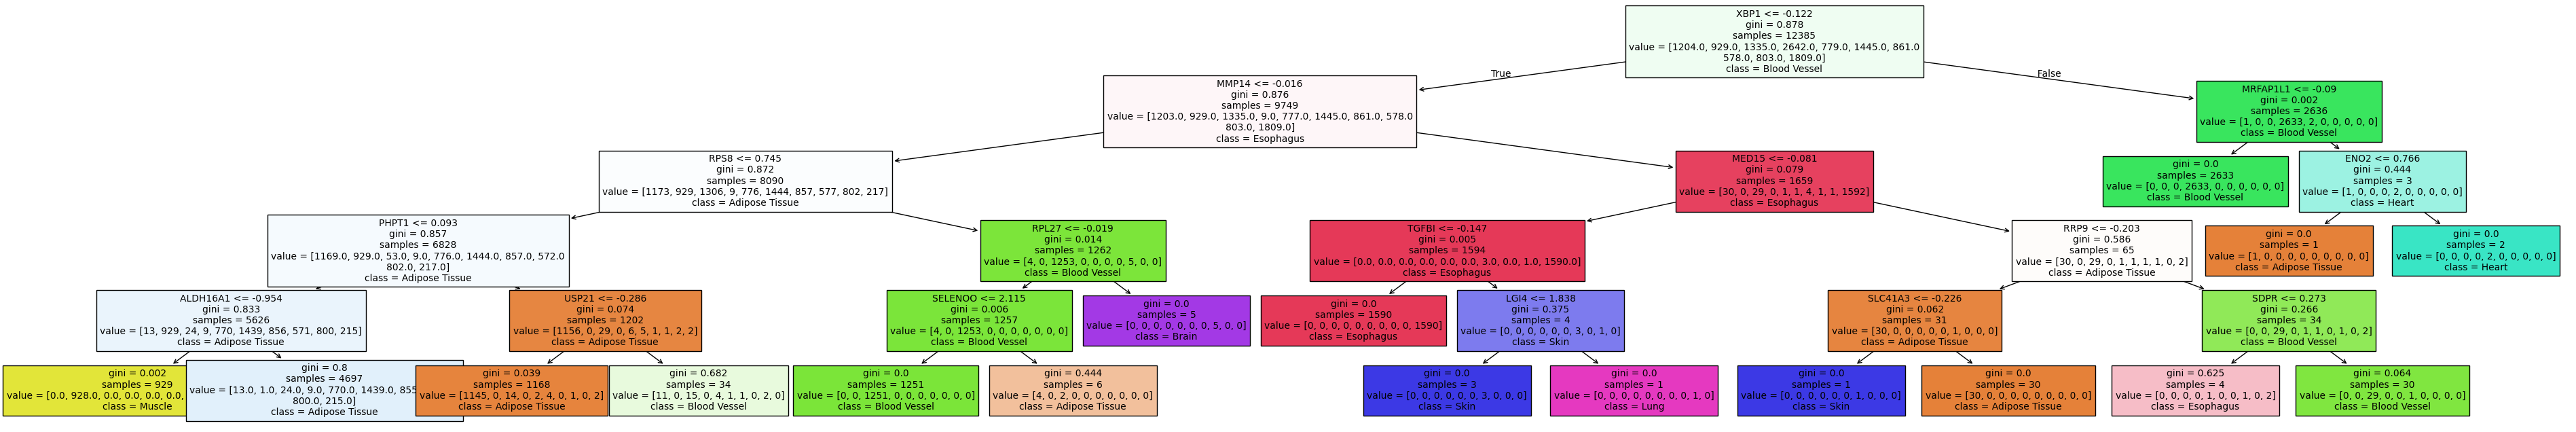

In [ ]:
fig = plt.figure(figsize=(48, 8))
_ = plot_tree(
    clt_truth,
    filled=True,
    fontsize=10,
    feature_names=feature_to_symbol.astype(str).iloc[:,0].tolist(),
    class_names=y.values
)